# Setup/imports

In [1]:
import numpy as np
import pandas as pd
import re
from load_dataset import *
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer

from IPython.display import display, Markdown
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
adult_X, adult_y = load_adult()
housing_X, housing_y = load_housing()

# Define and train models

In [3]:
def train_classification_models(X, y):
    """
    Trains three classification models on the Adult dataset:
      - Decision Tree, Random Forest, and MLP.
    Splits the data into train/test sets and prints test accuracy.
    
    Returns:
        models (dict): trained models.
        X_train, X_test, y_train, y_test: the train-test splits.
    """
    dt_clf = DecisionTreeClassifier(random_state=42)
    rf_clf = RandomForestClassifier(random_state=42)
    mlp_clf = MLPClassifier(random_state=42, max_iter=500)
    
    models = {
        'DecisionTree': dt_clf,
        'RandomForest': rf_clf,
        'MLP': mlp_clf
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"{name} Test Accuracy: {acc:.3f}")
    
    return models, X_train, X_test, y_train, y_test

def train_regression_models(X, y):
    """
    Trains three regression models on the Housing dataset:
      - Decision Tree, Random Forest, and MLP.
    Splits the data into train/test sets and prints test MSE.
    
    Returns:
        models (dict): trained models.
        X_train, X_test, y_train, y_test: the train-test splits.
    """
    dt_reg = DecisionTreeRegressor(random_state=42)
    rf_reg = RandomForestRegressor(random_state=42)
    mlp_reg = MLPRegressor(random_state=42, max_iter=500)
    
    models = {
        'DecisionTree': dt_reg,
        'RandomForest': rf_reg,
        'MLP': mlp_reg
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        print(f"{name} Test MSE: {mse:.3f}")
    
    return models, X_train, X_test, y_train, y_test


# Parse SHAP and LIME explanations

In [8]:
def get_shap_top_feature(model, X_train, test_instance, model_type='tree', mode='classification'):
    """
    Get most important feature for a given model when predicting a given instance (x_test).
    """
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    else:
        if mode == 'classification':
            explainer = shap.KernelExplainer(model.predict_proba, X_train, link="identity") 
        else:
            explainer = shap.KernelExplainer(model.predict, X_train, link="identity") 
    shap_values = explainer.shap_values(test_instance)
    if mode == 'classification':
        most_important_idx = np.argmax(np.abs(shap_values)[:, 1])
    else:
        most_important_idx = np.argmax(np.abs(shap_values))
    return adult_X.columns[most_important_idx]

def get_lime_top_feature(model, X_train, test_instance, mode='classification'):
    """
    Get most important feature for a given model when predicting a given instance (x_test).
    """
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns.tolist(),
        class_names=['class_0', 'class_1'] if mode == 'classification' else None,
        mode=mode,
        discretize_continuous=True
    )
    predict_fn = model.predict_proba if mode == 'classification' else model.predict
    explanation = explainer.explain_instance(
        data_row=test_instance,
        predict_fn=predict_fn,
        num_features=len(test_instance)
    )
    explanation_list = explanation.as_list()
    # Get the first tuple from the explanation list
    top_feature_raw, weight = explanation_list[0]
    # Extract the feature name (assumes the first alphabetical token is the feature name)
    match = re.search(r'([A-Za-z_-]+)', top_feature_raw)
    if match:
        top_feature = match.group(1)
    else:
        raise ValueError("Could not parse feature name from LIME explanation: " + top_feature_raw)
    
    return top_feature

def get_shap_feature_ranking(model, X_train, test_instance, model_type='tree', mode='classification'):
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, X_train, link="identity") 
    
    if mode == 'classification':
        shap_values = explainer.shap_values(test_instance)[:, 1] # For binary classification, we take the second class (class 1)
    else:
        shap_values = explainer.shap_values(test_instance)
    
    # Create a dictionary mapping feature names to their absolute SHAP values.
    feature_importance = {feature: abs(shap_val) for feature, shap_val in zip(X_train.columns, shap_values)}
    
    # Sort the features by importance (largest absolute SHAP value first)
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_features

def get_lime_feature_ranking(model, X_train, test_instance, mode='classification'):
    explainer = LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns.tolist(),
        mode=mode,
        discretize_continuous=True
    )
    
    predict_fn = model.predict_proba if mode == 'classification' else model.predict
    explanation = explainer.explain_instance(
        data_row=test_instance,
        predict_fn=predict_fn,
        num_features=len(test_instance)
    )
    
    explanation_list = explanation.as_list()
    feature_importances = []
    
    for condition, weight in explanation_list:
        # Extract the feature name using regex inline.
        match = re.search(r'^([A-Za-z_-]+)', condition)
        feature_name = match.group(1) if match else condition
        feature_importances.append((feature_name, abs(weight)))
    
    sorted_features = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    return sorted_features

def average_rank_std_from_dicts(dict_list):
    """
    Computes the average standard deviation of feature rank positions across multiple runs.
    """
    # Convert each dictionary to a ranking list by sorting the keys
    # in descending order of importance.
    rankings = []
    for d in dict_list:
        if isinstance(d, list):
            d = dict(d)
        ranking = sorted(d.keys(), key=lambda key: d[key], reverse=True)
        rankings.append(ranking)
        
    # Assume that each dictionary contains the same set of features.
    features = rankings[0]
    
    # Initialize a dictionary to record the rank positions for each feature.
    rank_positions = {feature: [] for feature in features}
    
    # Record the rank (index) for each feature in each ranking.
    for ranking in rankings:
        for i, feature in enumerate(ranking):
            rank_positions[feature].append(i)
    
    # Compute the standard deviation of rank positions for each feature.
    stds = [np.std(positions) for positions in rank_positions.values()]
    
    # Return the average standard deviation across all features.
    return np.mean(stds)


# Experiment Functions

In [5]:
def feature_removal_test(model_name, model, X_train, y_train, X_test, mode='classification'):

    shap_deltas = np.zeros(X_test.shape[0])
    lime_deltas = np.zeros(X_test.shape[0])

    for i, test_instance in tqdm(enumerate(X_test.values), total=X_test.shape[0]):

        if mode == 'classification':
            pred_before_removal = model.predict_proba(test_instance.reshape(1, -1))[0][1]
        else:
            pred_before_removal = model.predict(test_instance.reshape(1, -1))[0]

        model_type = 'tree' if model_name in ['DecisionTree', 'RandomForest'] else 'kernel'
        top_feature_shap = get_shap_top_feature(model, X_train, test_instance, model_type=model_type, mode=mode)
        top_feature_lime = get_lime_top_feature(model, X_train, test_instance, mode=mode)

        # Remove the top feature shap
        test_instance_modified = np.delete(test_instance, np.where(X_train.columns == top_feature_shap)[0][0])
        modified_model = copy.deepcopy(model)
        modified_model.fit(X_train.drop(columns=[top_feature_shap], inplace=False), y_train)
        if mode == 'classification':
            pred_after_removal = modified_model.predict_proba(test_instance_modified.reshape(1, -1))[0][1]
        else:
            pred_after_removal = modified_model.predict(test_instance_modified.reshape(1, -1))[0]
        delta_shap = np.abs(pred_before_removal - pred_after_removal)
        shap_deltas[i] = delta_shap

        # Remove the top feature lime
        test_instance_modified = np.delete(test_instance, np.where(X_train.columns == top_feature_lime)[0][0])
        modified_model = copy.deepcopy(model)
        modified_model.fit(X_train.drop(columns=[top_feature_shap], inplace=False), y_train)
        if mode == 'classification':
            pred_after_removal = modified_model.predict_proba(test_instance_modified.reshape(1, -1))[0][1]
        else:
            pred_after_removal = modified_model.predict(test_instance_modified.reshape(1, -1))[0]
        delta_lime = np.abs(pred_before_removal - pred_after_removal)
        lime_deltas[i] = delta_lime

    return {'shap': shap_deltas, 'lime': lime_deltas}

def stability_test(model_name, model, X_train, test_instance, num_rep, mode='classification'):
    list_of_shap_rankings = []
    list_of_lime_rankings = []
    for i in tqdm(range(num_rep)):
        rankings_shap = get_shap_feature_ranking(model, X_train, test_instance, model_type='tree' if model_name in ['DecisionTree', 'RandomForest'] else 'kernel', mode=mode)
        rankings_lime = get_lime_feature_ranking(model, X_train, test_instance, mode=mode)
        list_of_shap_rankings.append(rankings_shap)
        list_of_lime_rankings.append(rankings_lime)
    avg_rank_std_shap = average_rank_std_from_dicts(list_of_shap_rankings)
    avg_rank_std_lime = average_rank_std_from_dicts(list_of_lime_rankings)
    return {'shap': avg_rank_std_shap, 'lime': avg_rank_std_lime}


# Run Classification Experiments

DecisionTree Test Accuracy: 0.787
RandomForest Test Accuracy: 0.800
MLP Test Accuracy: 0.831


## Model: **DecisionTree**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

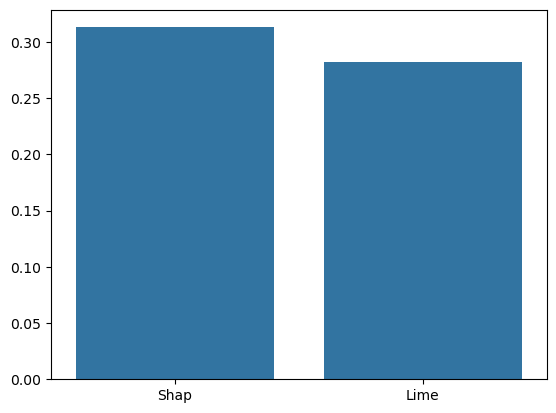

## Model: **RandomForest**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

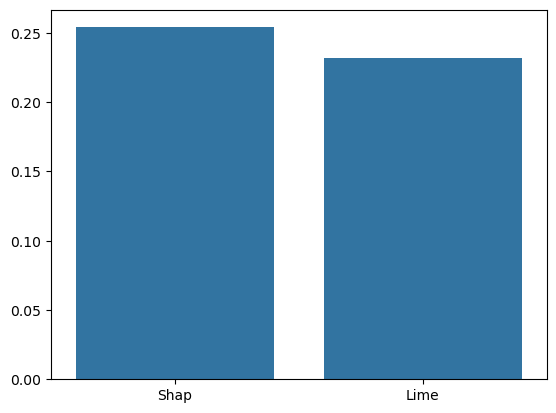

## Model: **MLP**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K s

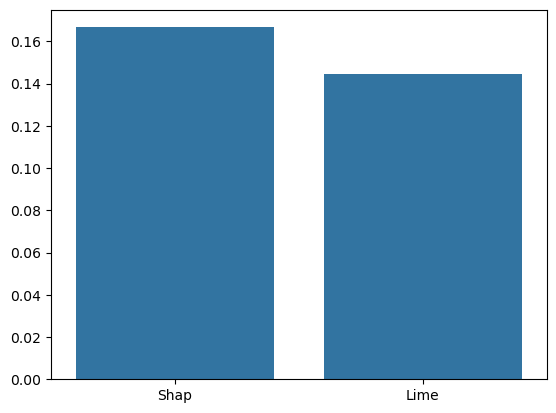

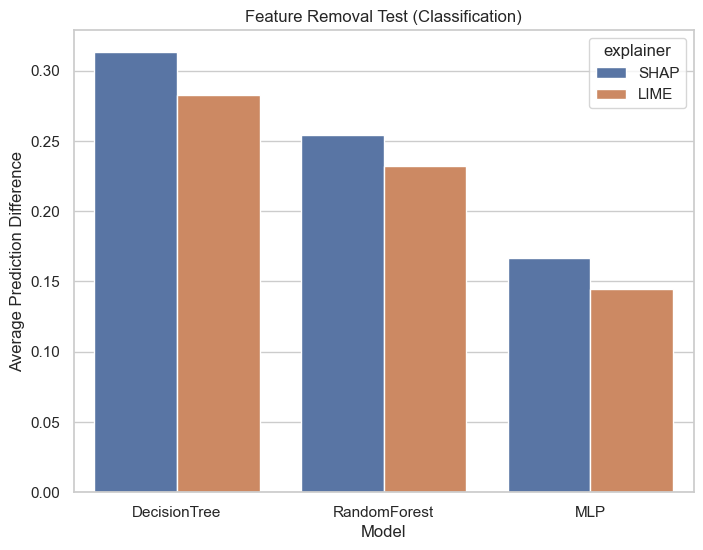

In [6]:
# Load dataset and train models
X, y = load_adult()
models, X_train, X_test, y_train, y_test = train_classification_models(X, y)

results = {
    'model': [],
    'feature_removal_test_shap': [],
    'feature_removal_test_lime': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Feature Removal Test
    display(Markdown("**Feature Removal Test:**"))
    feature_removal_test_results = feature_removal_test(name, model, X_train, y_train, X_test[:20], mode='classification')
    sns.barplot(x=['Shap', 'Lime'], y=[feature_removal_test_results['shap'].mean(), feature_removal_test_results['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['feature_removal_test_shap'].append(feature_removal_test_results['shap'].mean())
    results['feature_removal_test_lime'].append(feature_removal_test_results['lime'].mean())

df = pd.DataFrame(results)
df_long = pd.melt(df,
                id_vars='model',
                value_vars=['feature_removal_test_shap', 'feature_removal_test_lime'],
                var_name='explainer',
                value_name='feature_removal_test')
df_long['explainer'] = df_long['explainer'].replace({
    'feature_removal_test_shap': 'SHAP',
    'feature_removal_test_lime': 'LIME'
})
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='model', y='feature_removal_test', hue='explainer')
plt.title("Feature Removal Test (Classification)")
plt.xlabel("Model")
plt.ylabel("Average Prediction Difference")
plt.show()
    

# Run Regression Experiments

DecisionTree Test MSE: 0.178
RandomForest Test MSE: 0.140
MLP Test MSE: 0.115


## Model: **DecisionTree**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

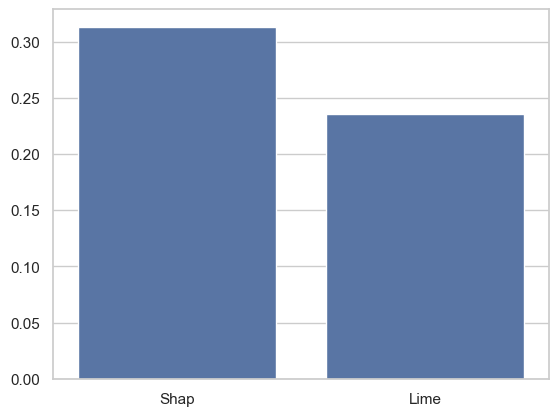

## Model: **RandomForest**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

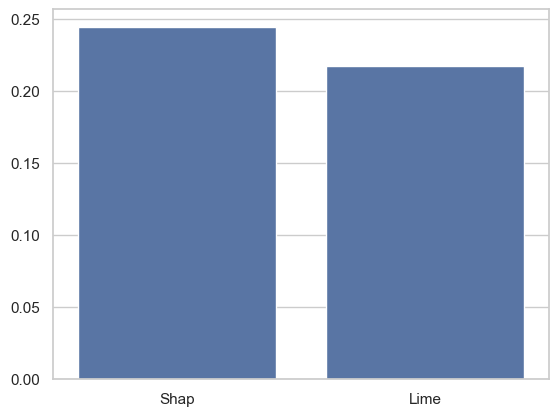

## Model: **MLP**

**Feature Removal Test:**

  0%|          | 0/20 [00:00<?, ?it/s]

Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 22792 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K s

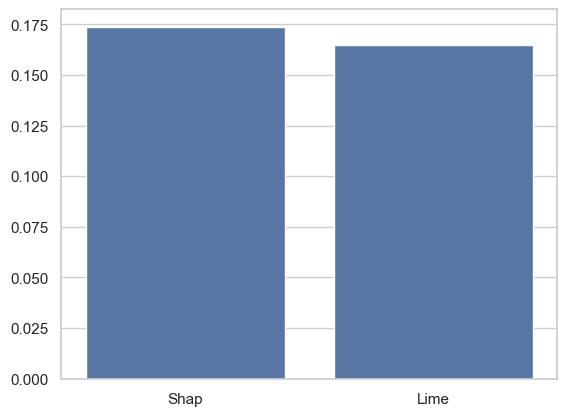

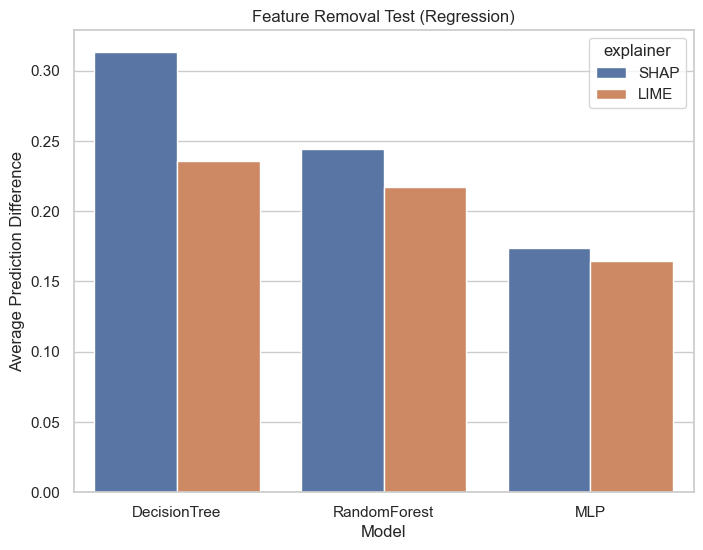

In [9]:
# Load dataset and train models
X, y = load_adult()
models, X_train, X_test, y_train, y_test = train_regression_models(X, y)

results = {
    'model': [],
    'feature_removal_test_shap': [],
    'feature_removal_test_lime': []
    }

for name, model in models.items():
    display(Markdown(f"## Model: **{name}**"))
    
    # Feature Removal Test
    display(Markdown("**Feature Removal Test:**"))
    feature_removal_test_results = feature_removal_test(name, model, X_train, y_train, X_test[:20], mode='regression')
    sns.barplot(x=['Shap', 'Lime'], y=[feature_removal_test_results['shap'].mean(), feature_removal_test_results['lime'].mean()])
    plt.show()

    results['model'].append(name)
    results['feature_removal_test_shap'].append(feature_removal_test_results['shap'].mean())
    results['feature_removal_test_lime'].append(feature_removal_test_results['lime'].mean())

df = pd.DataFrame(results)
df_long = pd.melt(df,
                id_vars='model',
                value_vars=['feature_removal_test_shap', 'feature_removal_test_lime'],
                var_name='explainer',
                value_name='feature_removal_test')
df_long['explainer'] = df_long['explainer'].replace({
    'feature_removal_test_shap': 'SHAP',
    'feature_removal_test_lime': 'LIME'
})
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='model', y='feature_removal_test', hue='explainer')
plt.title("Feature Removal Test (Regression)")
plt.xlabel("Model")
plt.ylabel("Average Prediction Difference")
plt.show()
